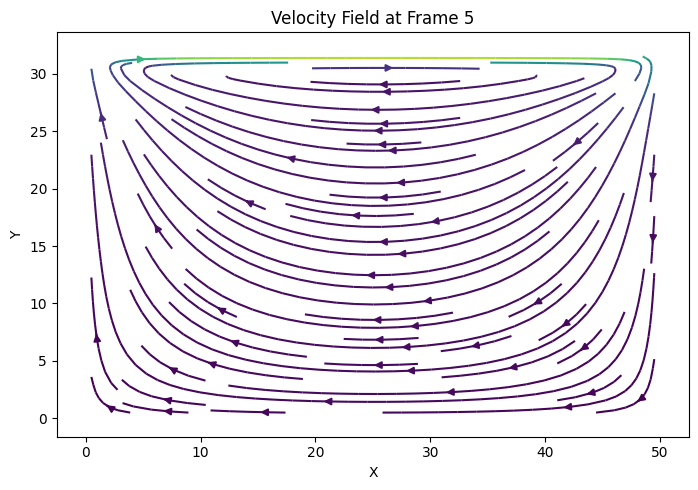

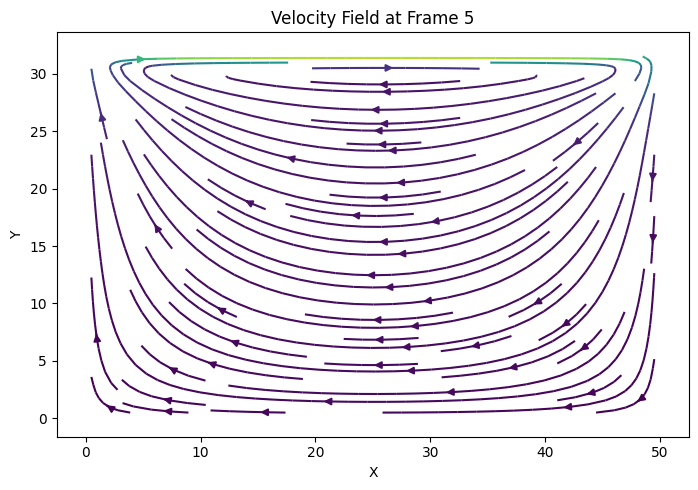

In [ ]:
from phi.jax.flow import *
from phi.flow import *

@jit_compile
def step(v, p, dt=1., viscosity=.1):
    v = advect.semi_lagrangian(v, v, dt)
    v = diffuse.explicit(v, viscosity, dt)
    v, p = fluid.make_incompressible(v, solve=Solve(x0=p))
    return v, p

# 设置边界条件和初始速度场
boundary = {'x': 0, 'y-': 0, 'y+': vec(x=1, y=0)}
v0 = StaggeredGrid(0, boundary, x=50, y=32)

# 进行仿真，生成速度场轨迹 v_trj 和压力场轨迹 p_trj
v_trj, p_trj = iterate(step, batch(time=19), v0, None)

# 选择特定时间步的帧，例如选择第 5 帧
frame_index = 5  # 你可以替换成你需要的任何索引

# 从轨迹中获取特定的帧
frame_at_time = v_trj.time[frame_index]

# 绘制该帧
plot(frame_at_time, title=f"Velocity Field at Frame {frame_index}")


In [ ]:
from phi.flow import *
from scipy.ndimage import zoom


def cubic_velocity_sample(phi: Field, eta: float) -> Field:
    """
    Cubically downsamples a StaggeredGrid velocity field by a factor of eta using bicubic interpolation.

    Args:
        grid (StaggeredGrid): The input StaggeredGrid velocity field to downsample.
        eta (float): Downsampling factor (e.g., 0.5 for half resolution), or upsampling factor (e.g., 2.0 for double resolution).

    Returns:
        StaggeredGrid: Downsampled velocity field using cubic interpolation.
    """
    assert phi.is_staggered, "Input grid must be a StaggeredGrid."

    # Dictionary to hold downsampled velocity components
    downsampled_values = {}

    # Loop through each velocity component ('x', 'y', etc.)
    for dim in phi.vector.item_names:
        # Get the velocity component values
        component_values = phi.values[dim]

        if dim is "x":
            downsampled_x = zoom(component_values, (eta, eta), order=3)
        if dim is "y":
            downsampled_xy = zoom(downsampled_x, (eta, eta), order=3)

        # Store downsampled component in dictionary
        downsampled_values[dim] = downsampled_xy

    # Stack the downsampled components to form a new StaggeredGrid
    downsampled_grid = StaggeredGrid(math.stack(downsampled_values, dual('vector')),boundary=phi.boundary,bounds=phi.bounds)

    return downsampled_grid

# Example usage
v = cubic_velocity_sample(frame_at_time, 0.2)
plot(v)

AssertionError: Failed to get native tensor because dims ['y'] were not specified in the dim order. Got ('x',) for tensor (xˢ=49, yˢ=32)

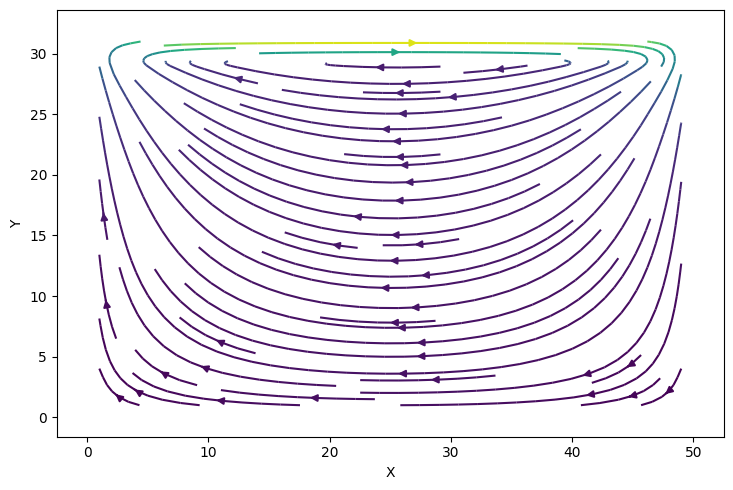

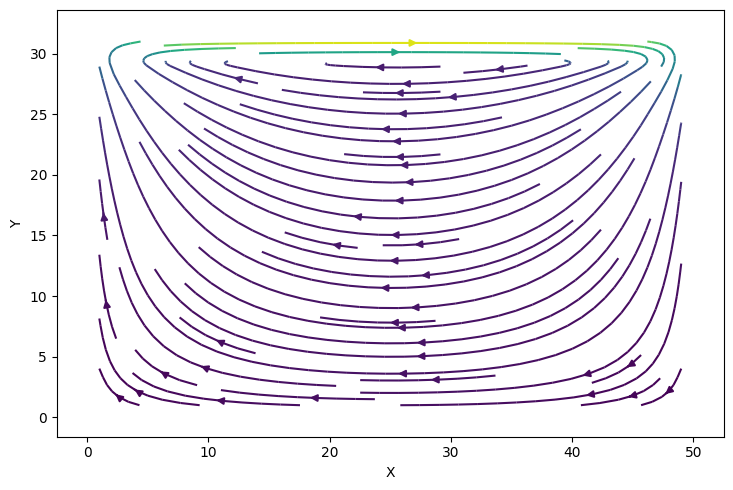

In [ ]:
from phi.field import downsample2x
v=downsample2x(frame_at_time)
plot(v)